In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Calculate moving averages
def moving_average(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()
    #nreturn data['Close'].rolling(window=window).mean()

In [3]:
def exponential_moving_average(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()

In [4]:
# Calculate momentum
def momentum(data, window):
    return data['Close'].diff(window - 1)

In [5]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [6]:
def adx(data, window=14):

    # Calculate True Range
    data['tr0'] = abs(data['High'] - data['Low'])
    data['tr1'] = abs(data['High'] - data['Close'].shift())
    data['tr2'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['tr0', 'tr1', 'tr2']].max(axis=1)

    # Calculate Directional Movement
    data['DMplus'] = np.where((data['High'] - data['High'].shift()) > (data['Low'].shift() - data['Low']), data['High'] - data['High'].shift(), 0)
    data['DMminus'] = np.where((data['Low'].shift() - data['Low']) > (data['High'] - data['High'].shift()), data['Low'].shift() - data['Low'], 0)

    # Calculate Smoothed True Range
    data['ATR'] = data['TR'].rolling(window=window).mean()

    # Calculate Smoothed Directional Movement
    data['ADMplus'] = data['DMplus'].rolling(window=window).mean()
    data['ADMminus'] = data['DMminus'].rolling(window=window).mean()

    # Calculate Directional Index
    data['DIplus'] = (data['ADMplus'] / data['ATR']) * 100
    data['DIminus'] = (data['ADMminus'] / data['ATR']) * 100

    data['DX'] = abs(data['DIplus'] - data['DIminus']) / (data['DIplus'] + data['DIminus']) * 100

    adx_values = data['DX'].rolling(window=window).mean()

    return (adx_values, data['DIplus'], data['DIminus'])

In [7]:
# Trading strategy combining moving average crossover, momentum, and VWAP
def trading_strategy(data, complete=False, rsi_window=None, overbought_threshold=None, oversold_threshold=None, adx_window=None, adx_threshold=None, short_window=None, long_window=None):
    signals = pd.DataFrame(index=data.index)
    signals['Date'] = pd.to_datetime(data['Date'])
    signals['signal'] = 0.0

        
    # Moving average crossover
    if short_window:
        signals['short_mavg'] = moving_average(data, short_window)
        signals['long_mavg'] = moving_average(data, long_window)
        signals['signal_ma'] = 0.0
        # Place buy order when short moving average crosses above long moving average
        signals.loc[(signals['short_mavg'].shift(1) < signals['long_mavg'].shift(1)) & (signals['short_mavg'] > signals['long_mavg']), 'signal_ma'] = 1.0

        # Place sell order when short moving average crosses below long moving average
        signals.loc[(signals['short_mavg'].shift(1) > signals['long_mavg'].shift(1)) & (signals['short_mavg'] < signals['long_mavg']), 'signal_ma'] = -1.0
        
    if rsi_window:
        rsi_values = calculate_rsi(data, window=rsi_window)
        signals['signal_rsi'] = 0.0
        signals['rsi'] = rsi_values
        signals.loc[signals['rsi'] > overbought_threshold, 'signal_rsi'] = -1.0
        signals.loc[signals['rsi'] < oversold_threshold, 'signal_rsi'] = 1.0

    if adx_window:
        adx_values = adx(data, window=adx_window)
        signals['signal_adx'] = 0.0
        signals['adx'] = adx_values[0]
        signals['+DI'] = adx_values[1]
        signals['-DI'] = adx_values[2]
        signals.loc[(signals['+DI'].shift(1) < signals['-DI'].shift(1)) & (signals['+DI'] > signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = 1.0
    
        # Place sell signal when -DI crosses over +DI and ADX is above the threshold
        signals.loc[(signals['+DI'].shift(1) > signals['-DI'].shift(1)) & (signals['+DI'] < signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = -1.0
        
        
    if complete:
        signals_sum = signals['signal_ma'] + signals['signal_rsi'] + signals['signal_adx']
        signals['sum'] = signals_sum
        signals['signal'] = 0.0
        signals.loc[signals['sum'] >= 2.0, 'signal'] = 1.0
        signals.loc[signals['sum'] <= -2.0, 'signal'] = -1.0
            
    elif short_window:
        signals['signal'] = signals['signal_ma']
    elif rsi_window:
        signals['signal'] = signals['signal_rsi']
    elif adx_window:
        signals['signal'] = signals['signal_adx']
    return signals

In [8]:
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2019-01-01']

In [9]:
signals = trading_strategy(df, short_window=20, long_window=70)
signals.to_csv("MSFT_signal_ma.csv")
signals = trading_strategy(df, adx_window=14, adx_threshold=25)
signals.to_csv("MSFT_signal_adx.csv")
signals = trading_strategy(df, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_signal_rsi.csv")
signals = trading_strategy(df, complete=True, short_window=10, long_window=11, adx_window=14, adx_threshold=25, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_complete_signal.csv")

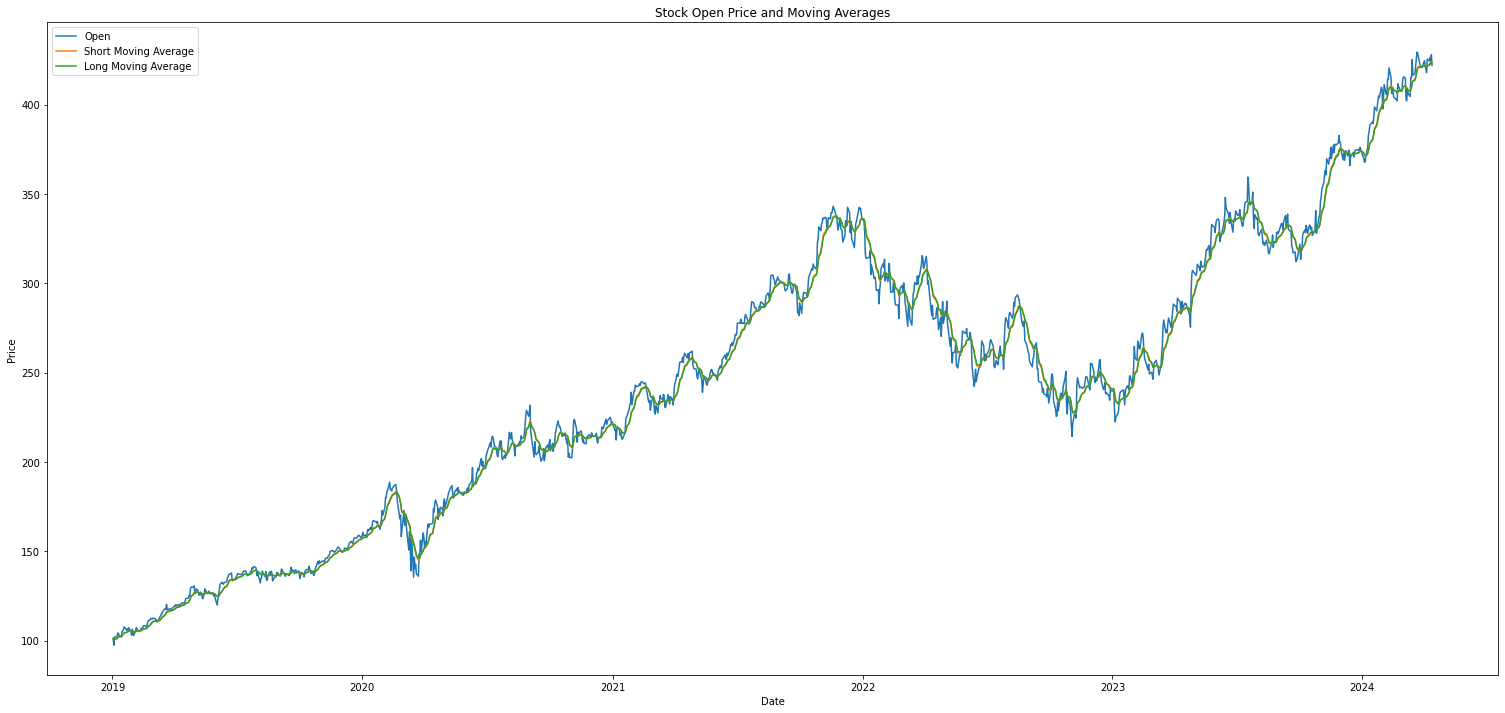

In [10]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['short_mavg'].values, label='Short Moving Average')
plt.plot(signals['Date'].values, signals['long_mavg'].values, label='Long Moving Average')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

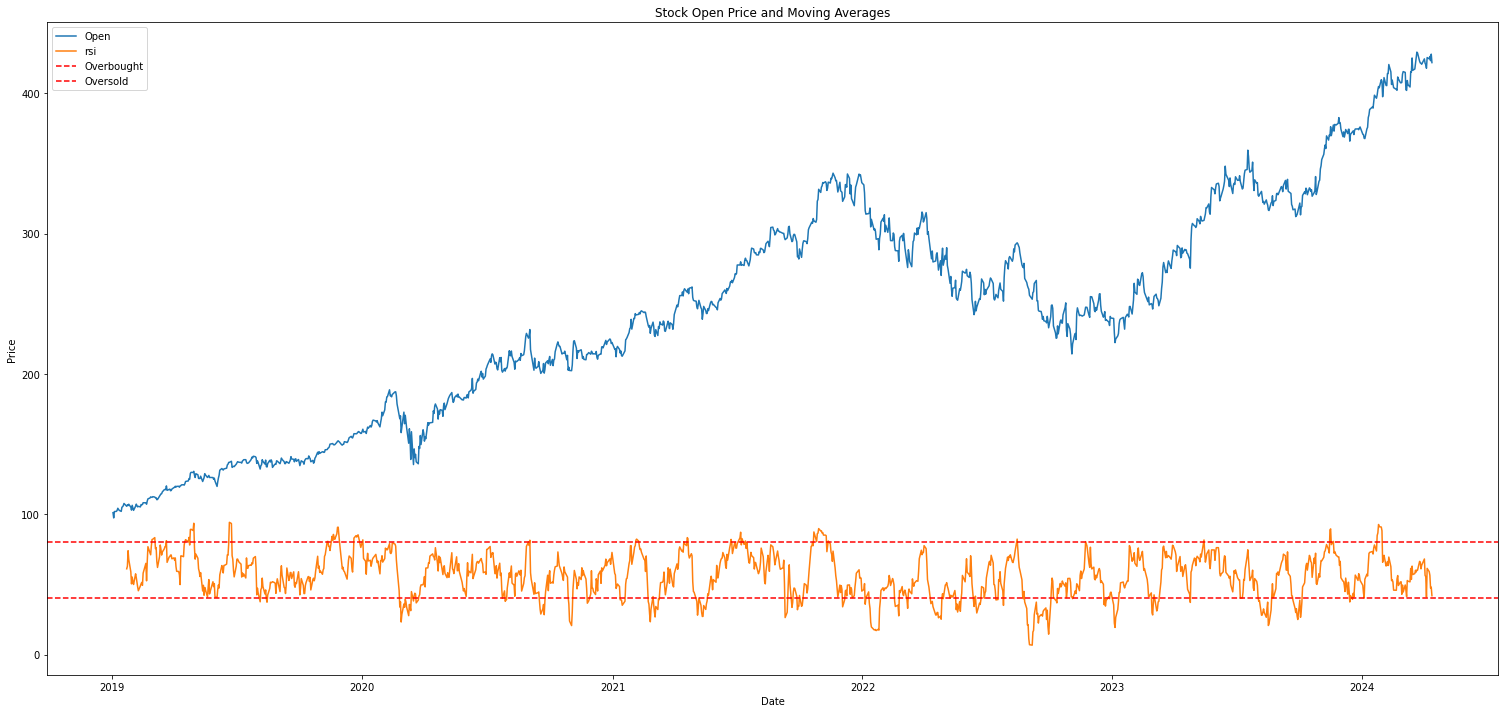

In [11]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['rsi'].values, label='rsi')
plt.axhline(y=80, color='r', linestyle='--', label='Overbought')
plt.axhline(y=40, color='r', linestyle='--', label='Oversold')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

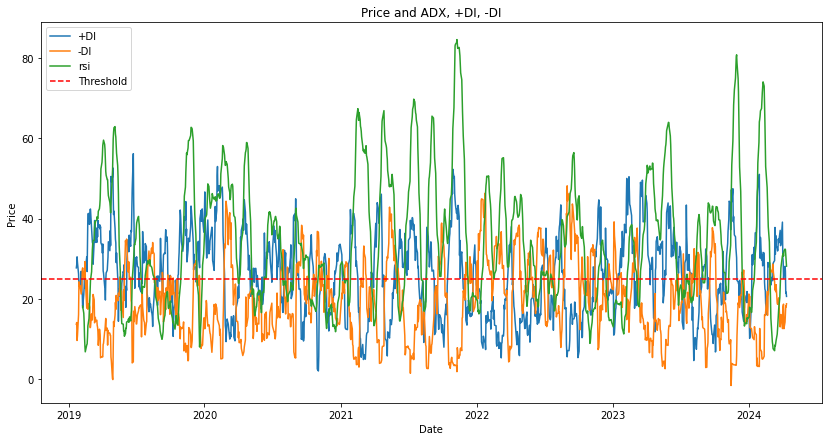

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(signals['Date'].values, signals['+DI'].values, label='+DI')
plt.plot(signals['Date'].values, signals['-DI'].values, label='-DI')
plt.plot(signals['Date'].values, signals['adx'].values, label='rsi')
plt.axhline(y=25, color='r', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and ADX, +DI, -DI')
plt.legend()
plt.show()

In [ ]:

def backtest_strategy(data, initial_cash, transaction_cost, stop_loss, take_profit, **kwargs):
    signals = trading_strategy(data, **kwargs)

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['Cash'] = initial_cash
    portfolio['Position'] = 0.0
    portfolio['pnl'] = 0
    portfolio['g_sl'] = 0
    portfolio['g_tp'] = 0
    portfolio['close'] = 0
    portfolio['amount'] = 0
    portfolio['multiplier'] = 0
    portfolio['Cash'] = portfolio['Cash'].astype(float)
    portfolio['Position'] = portfolio['Position'].astype(float)
    portfolio['pnl'] = portfolio['pnl'].astype(float)
    portfolio['g_sl'] = portfolio['g_sl'].astype(float)
    portfolio['g_tp'] = portfolio['g_tp'].astype(float)
    portfolio['close'] = portfolio['close'].astype(float)
    portfolio['amount'] = portfolio['amount'].astype(float)
    portfolio['multiplier'] = portfolio['multiplier'].astype(float)
    global sl, tp, buy, sell, amount, pnl, no_trades, no_wins, multiplier
    sl = 0
    tp = 0
    buy = False
    sell = False
    pnl = 0
    amount = 0
    no_trades = 0
    no_wins = 0
    multiplier = 0
    
    cash_balance = initial_cash  # Initialize cash balance
    
    for index, row in signals.iterrows():
        signal = row['signal']
        price = data.loc[index, 'Close']
        stop_loss_price = price - (stop_loss * price)
        take_profit_price = price + (take_profit * price)
        
        
        if signal == 1.0 and cash_balance >= price * multiplier and tp == 0:
            # Buy
            amount = price
            multiplier = round(initial_cash/amount, 2)
            portfolio.loc[index, 'Position'] = 1.0
            cash_balance -= price * multiplier
            tp = take_profit_price
            sl = stop_loss_price
            buy = True
        elif signal == -1.0 and cash_balance >= price * multiplier and tp == 0:
            # Sell
            amount = price
            multiplier = round(initial_cash/amount, 2)
            portfolio.loc[index, 'Position'] = -1.0
            cash_balance -= price * multiplier
            tp = stop_loss_price
            sl = take_profit_price
            sell = True
        
        if price >= tp and buy:
            cash_balance += (amount*multiplier) + ((tp - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price <= sl and buy:
            cash_balance += (amount*multiplier) + ((sl - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            multiplier = 0
        if price <= tp and sell:
            cash_balance += (amount*multiplier) + ((amount - tp)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price >= sl and sell:
            cash_balance += (amount*multiplier) + ((amount - sl)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            multiplier = 0
            
        if index == signals.index[-1] and buy:
            cash_balance += (amount*multiplier) + ((price - amount)*multiplier)
        elif index == signals.index[-1] and sell:
            cash_balance += (amount*multiplier) + ((amount - price)*multiplier)
            
        pnl = cash_balance - initial_cash
        
        # Update portfolio value
        portfolio.loc[index, 'Cash'] = round(cash_balance, 2)
        portfolio.loc[index, 'amount'] = round(amount, 2)
        portfolio.loc[index, 'pnl'] = round(pnl, 2)
        portfolio.loc[index, 'g_sl'] = round(sl, 2)
        portfolio.loc[index, 'g_tp'] = round(tp, 2)
        portfolio.loc[index, 'close'] = round(price, 2)
        portfolio.loc[index, 'multiplier'] = round(multiplier, 2)
        portfolio.loc[index, 'no_trades'] = int(no_trades)
        portfolio.loc[index, 'no_wins'] = int(no_wins)

    sl = 0
    tp = 0
    pnl = 0
    amount = 0

    return portfolio

def win_percentage(portfolio):
    no_wins = portfolio.iloc[-1]['no_wins']
    no_trades = portfolio.iloc[-1]['no_trades']
    if no_trades == 0:
        return 0
    else:
        return round((no_wins / no_trades) * 100, 2)

In [49]:
def results(df):
    '''
    print("\nMoving Average:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=20, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=50, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=30, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=50, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=70, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=100, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=30, long_window=100, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=40, long_window=100, stop_loss=0.05, take_profit=0.05)
    print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    print("\nADX:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=0.05, take_profit=0.05)
    print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    print("\nRSI:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.05)
    print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))'''

    print("\nComplete:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio.to_csv("portfolio.csv")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))


In [50]:
# Microsoft
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Microsoft")
results(df)

Microsoft

Complete:
Complete Fast, Total Profit/Loss: 165.38 , No-Trades: 35.0  Win%: 40.0
Complete Normal, Total Profit/Loss: 165.08 , No-Trades: 22.0  Win%: 50.0
Complete Slow, Total Profit/Loss: 0.14 , No-Trades: 5.0  Win%: 20.0


In [51]:
# Apple
df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Apple")
results(df)

Apple

Complete:
Complete Fast, Total Profit/Loss: 130.84 , No-Trades: 30.0  Win%: 43.33
Complete Normal, Total Profit/Loss: 105.12 , No-Trades: 29.0  Win%: 34.48
Complete Slow, Total Profit/Loss: 34.95 , No-Trades: 8.0  Win%: 37.5


In [52]:
# JP Morgan
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("JP Morgan")
results(df)

JP Morgan

Complete:
Complete Fast, Total Profit/Loss: 60.15 , No-Trades: 29.0  Win%: 34.48
Complete Normal, Total Profit/Loss: 40.22 , No-Trades: 22.0  Win%: 27.27
Complete Slow, Total Profit/Loss: 10.0 , No-Trades: 8.0  Win%: 25.0


In [53]:
# Bank of America
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Bank of America")
results(df)

Bank of America

Complete:
Complete Fast, Total Profit/Loss: 76.94 , No-Trades: 34.0  Win%: 35.29
Complete Normal, Total Profit/Loss: 10.06 , No-Trades: 23.0  Win%: 21.74
Complete Slow, Total Profit/Loss: 10.02 , No-Trades: 8.0  Win%: 25.0


In [54]:
# Pfizer
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Pfizer")
results(df)

Pfizer

Complete:
Complete Fast, Total Profit/Loss: 45.0 , No-Trades: 33.0  Win%: 27.27
Complete Normal, Total Profit/Loss: -0.01 , No-Trades: 25.0  Win%: 20.0
Complete Slow, Total Profit/Loss: 4.97 , No-Trades: 9.0  Win%: 22.22


In [55]:
# Johnson & Johnson
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Johnson & Johnson")
results(df)

Johnson & Johnson

Complete:
Complete Fast, Total Profit/Loss: 47.71 , No-Trades: 12.0  Win%: 41.67
Complete Normal, Total Profit/Loss: 30.19 , No-Trades: 14.0  Win%: 28.57
Complete Slow, Total Profit/Loss: 34.93 , No-Trades: 7.0  Win%: 42.86


In [70]:
def loop(df):
    n=0
    for take_profit in take_profit_values:
        portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
        pnl_list[n] = pnl_list[n] + portfolio.iloc[-1]['pnl']
        n+=1

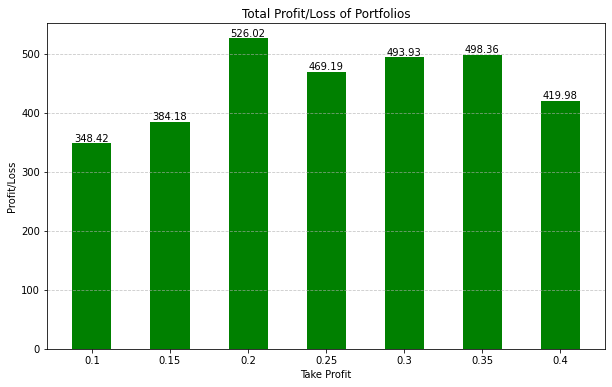

In [73]:
take_profit_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
pnl_list = []

df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

for take_profit in take_profit_values:
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
    pnl_list.append(portfolio.iloc[-1]['pnl'])

df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']
loop(df)
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']
loop(df)
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']
loop(df)
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']
loop(df)
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']
loop(df)
    
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each value
bar_width = 0.5
index = np.arange(len(take_profit_values))
bars = ax.bar(index, pnl_list, bar_width, color=['green' if pl >= 0 else 'red' for pl in pnl_list])

# Add labels, title, and grid
ax.set_xlabel('Take Profit')
ax.set_ylabel('Profit/Loss')
ax.set_title('Total Profit/Loss of Portfolios')
ax.set_xticks(index)
ax.set_xticklabels(take_profit_values)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(pnl_list[i],2)), ha='center', va='bottom')

plt.show()

In [75]:
def complete_loop(df):
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    total_pnl[0] = total_pnl[0] + portfolio.iloc[-1]['pnl']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    total_pnl[1] = total_pnl[1] + portfolio.iloc[-1]['pnl']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    total_pnl[1] = total_pnl[1] + portfolio.iloc[-1]['pnl']

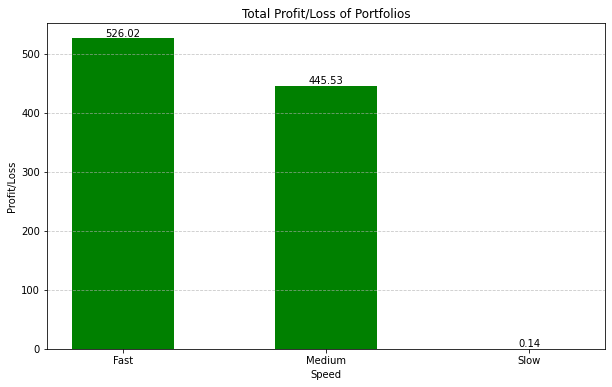

In [76]:
total_pnl=[]


df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=40, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=20, long_window=50, adx_window=30, adx_threshold=60, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])

df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each value
bar_width = 0.5
index = np.arange(len(total_pnl))
bars = ax.bar(index, total_pnl, bar_width, color=['green' if pl >= 0 else 'red' for pl in pnl_list])

# Add labels, title, and grid
ax.set_xlabel('Speed')
ax.set_ylabel('Profit/Loss')
ax.set_title('Total Profit/Loss of Portfolios')
ax.set_xticks(index)
ax.set_xticklabels(['Fast', 'Medium', 'Slow'])
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(total_pnl[i],2)), ha='center', va='bottom')

plt.show()